In [0]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

spark = SparkSession.builder.getOrCreate()

In [0]:
from pyspark.sql.functions import col, explode, lower, udf, collect_set, size, abs, lit, array, when
from pyspark.sql.types import IntegerType, StringType, ArrayType, StructType
from collections import Counter
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
from matplotlib.transforms import ScaledTranslation
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np

In [0]:
profiles = spark.read.parquet('/linkedin/people')

# Task 1: current positions and number of occurrences - Scraping Purposes

In [0]:
profiles.display(5)

about avatar certifications city country_code current_company current_company:company_id current_company:name education educations_details experience followers following groups id languages name people_also_viewed position posts recommendations recommendations_count timestamp url volunteer_experience сourses position_lower null https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry List() Sunnyside, Washington, United States US List(sunnyside-unified-school-district, Sunnyside Unified School District, https://eg.linkedin.com/company/sunnyside-unified-school-district?trk=public_profile_topcard-current-company, Sunnyside Unified School District, Special Services Director at Sunnyside Unified School District) sunnyside-unified-school-district Sunnyside Unified School District List() null List(List(null, null, null, null, null, null, null, null, null, Sunnyside Unified School District, https://eg.linkedin.com/company/sunnyside-unified-school-district?trk=public_profile_experience-item_profile-section-card_subtitle-click, Special Services Director, null)) 1 1 List() cody-gardiner-7a039667 List() cody gardiner List() Special Services Director at Sunnyside Unified School District List() List() null 2023-09-04 https://www.linkedin.com/in/cody-gardiner-7a039667 List() List() special services director at sunnyside unified school district null https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry List() Spring, Texas, United States US List(null, N/A, null, N/A, Retired at N/A) null N/A List(List(Bachelor of Arts (BA), 1963, Elementary Education and Teaching, 1959 - 1963, 1959, Baylor University, https://www.linkedin.com/school/baylor-university/?trk=public_profile_school_profile-section-card_image-click)) Baylor University List(List(null, null, null, null, null, null, null, null, null, N/A, null, Retired, null)) 13 13 List() sharon-tunnell-436474104 List() Sharon Tunnell List() Retired at N/A List() List() null 2023-09-04 https://www.linkedin.com/in/sharon-tunnell-436474104 List() List() retired at n/a null https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry List() United States US List(null, null, null, null, --) null null List() null List() 62 62 List() teresa-fulford-25a59a4b List() Teresa Fulford List() -- List() List() null 2023-09-04 https://www.linkedin.com/in/teresa-fulford-25a59a4b List() List() -- hard worker goal oriented and willing to work https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry List() Cleveland, Ohio, United States US List(dfas, DFAS, https://cn.linkedin.com/company/dfas?trk=public_profile_topcard-current-company, DFAS, Military Pay Technician at DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio) dfas DFAS List(List(null, 2005, null, 2004 - 2005 Received training in radio and television broadcast and production techniques. Skilled in operation of various audio and video studio equipment. Hands-on experience with Cool-Edit audio workstation. Practice with copy and news writing skills. Have maintained perfect attendance., 2004, OHIO CENTER FOR BROADCASTING, null), List(Bachelor of General Studies, 1999, General Studies of Art & Science, 1994 - 1999 Activities: Kent Interhall Council, Channels 45/49 Public Television, TV2, and Black United Students., 1994, Kent State University, https://cn.linkedin.com/school/kent-state-university/?trk=public_profile_school_profile-section-card_image-click)) OHIO CENTER FOR BROADCASTING List(List(DFAS, dfas, null, 14 years 8 months, null, null, null, List(List(Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Feb 2009 - Present 14 years 8 months, 14 years 8 months, Present, Feb 2009 - Present14 years 8 months , Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Feb 2009, DFAS, Military Pay Technician), List(Responsible for handling retired military pay accounts 

In [0]:
profiles.printSchema()

root
 |-- about: string (nullable = true)
 |-- avatar: string (nullable = true)
 |-- certifications: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- meta: string (nullable = true)
 |    |    |-- subtitle: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- current_company: struct (nullable = true)
 |    |-- company_id: string (nullable = true)
 |    |-- industry: string (nullable = true)
 |    |-- link: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- title: string (nullable = true)
 |-- current_company:company_id: string (nullable = true)
 |-- current_company:name: string (nullable = true)
 |-- education: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- degree: string (nullable = true)
 |    |    |-- end_year: string (nullable = true)
 |    |    |-- field: string (nullable = true

In [0]:
examples = profiles.select("position")
examples.display()

position Special Services Director at Sunnyside Unified School District Retired at N/A -- Military Pay Technician at DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio Senior Underwriter at Tokio Marine Insurance -- -- -- Traffic control supervisor/T.C.L. Union member 242 Laborers union Doctor of Occupational Therapy Student Director at Republic Services -- -- -- Teacher at Round Rock ISD Clerk at Caregiver Homes -- Reunification Services, Divorce Coaching, Complex Relationship Counseling, Parenting Coordination, Co-Parenting Education, Adult Mental Behavioral Health, Associate Managing Editor at St. Martin's Press Credit Analyst 5G Expert | Edge Technology | Spectrum | Infrastructure Director/Accounting at Southwest Gas Corporation null -- PCA at Elite Home Health Agency, Inc. -- Estimator at Red River Electric Inc. General Manager in Training at Flow Automotive Companies Student at The University of Texas at Arlington -- RGM at Capital Pizza Huts Strategy and Transactions Senior Associate at EY -- Director of Research & Business Operations at Washington University School of Medicine in St. Louis Senior Legal Administrative Assistant at Allstate Insurance Owner -- Owner, PIMS Graduate Student - CUNY Brooklyn College President at ashford const Owner, Little Apples Learning Center Animator en Respawn Entertainment Senior Engineer Practice Development Coordinator at Ropes & Gray LLP Senior Escrow Assistant/ Closing Coordinator at Stewart Vacation Ownership Assurity Title -- Director International Sales at Ice-O-Matic -- -- null Accounts Payable, Customer Service, Mail-room Clerk, HTS Tariff Coding Bank Teller at Wells Fargo -- Shipping receiving @Brookdale Honda -- Accounting Professional Actively looking to improve my career in Business Administration Management Assistant Operations Manager at TrailWest Bank -- -- Senior Collections Specialist II at Stearns Bank N.A. Flight Mechanic Student at Stanbridge College -- billing specialist -- Teacher employee at Sam's club owner Family Support Project Coordinator at Boone County Social Services -- -- -- Waitress at Acapulco Mexican Restaurant Loan Specialist Commercial Real Estate Loans: Purchase-New Construction-Fix & Flip | SBA Loans, Franchise - Start-ups | ABL - Health Care - Equipment Financing retired attorney I aspire to help individuals identify personal challenges & transform lives by understanding behavior & mental process. My goal is to provide education & resources through integrity & support. General manager sales advisor at club demonstration services Assistant Manager Ex HDFC Bank , Certified on Investment Banking, Fund, Equity, Capital Market Valuations, M&A, AML & KYC Sales at Dillards dept store Retired at State of Louisiana -- Morgan State University sophomore in strategic communications vice president Hills farms Inc at Oak Ridge Apparel & Awards Military Professional Medical Assistant Instructor Assistant Marketing Manager Firefighter/Paramedic at City of Brisbane -- -- Etowah County DHR JOBS Case Manager at Alabama Department of Human Resources -- Professor of Violin at Texas Christian University SaaS | Diversity | OFCCP Compliance Solutions | Coach | Golf Enthusiast -- Student at Xavier University of Louisiana at Clear Channel Outdoor -- Digital Marketing Manager -- null -- Senior Finance Manager at Johnson & Johnson Capellan at ARC. Ejercito de Salvacion null null null PRESIDENT at GREYSTONE REALTY LLC management at grand blanc printing Assistant Store Manager at Embrace A Change 4 Life with TSFL Health Coaching -- Sales Account Manager at Delphi Packard Electric Recipient of 2017 Brava Executive Category Award at DSA Inc -- sales rep at Ace Distributors Senior Sales and Marketing Manager at Century Moving, Inc. -- RN at GRDHD -- Manager, Quality Programs at City of Memphis Owner at Probe Enterprises at Fort Bend ISD -- Para-Maize USD 266 -- Tax Processor at Intuit Software Release Manager/Scaled Scrum Master at State Street 

In [0]:
profiles = profiles.withColumn("position_lower", lower(col("position")))
positions_list = profiles.select("position_lower").rdd.flatMap(lambda x: x).collect()

In [0]:
print(type(positions_list))
print(f"number of positions: {len(positions_list):,}")

<class 'list'>
number of positions: 3,462,290


In [0]:
for i in range(20):
    print(f"example [{i+1}]: {positions_list[i]}")

example [1]: special services director at sunnyside unified school district
example [2]: retired at n/a
example [3]: --
example [4]: military pay technician at defense finance and accounting service-cleveland retired annuitant pay cleveland ohio
example [5]: senior underwriter at tokio marine insurance
example [6]: --
example [7]: --
example [8]: --
example [9]: traffic control supervisor/t.c.l. union member 242 laborers union
example [10]: doctor of occupational therapy student
example [11]: director at republic services
example [12]: --
example [13]: --
example [14]: --
example [15]: teacher at round rock isd
example [16]: clerk at caregiver homes
example [17]: --
example [18]: reunification services, divorce coaching, complex relationship counseling, parenting coordination, co-parenting education, adult mental behavioral health,
example [19]: associate managing editor at st. martin's press
example [20]: credit analyst


In [0]:
# drop the "--"
print(f">>> prior to dropping '--', there were: {len(positions_list):,} values")
positions_list = [x for x in positions_list if x != "--"]
print(f">>> after droppping: {len(positions_list):,} values")

>>> prior to dropping '--', there were: 3,462,290 values
>>> after droppping: 2,672,278 values


In [0]:
for i in range(20):
    print(f"example [{i+1}]: {positions_list[i]}")

example [1]: special services director at sunnyside unified school district
example [2]: retired at n/a
example [3]: military pay technician at defense finance and accounting service-cleveland retired annuitant pay cleveland ohio
example [4]: senior underwriter at tokio marine insurance
example [5]: traffic control supervisor/t.c.l. union member 242 laborers union
example [6]: doctor of occupational therapy student
example [7]: director at republic services
example [8]: teacher at round rock isd
example [9]: clerk at caregiver homes
example [10]: reunification services, divorce coaching, complex relationship counseling, parenting coordination, co-parenting education, adult mental behavioral health,
example [11]: associate managing editor at st. martin's press
example [12]: credit analyst
example [13]: 5g expert | edge technology | spectrum | infrastructure
example [14]: director/accounting at southwest gas corporation
example [15]: None
example [16]: pca at elite home health agency, in

In [0]:
# drop the None values
print(f">>> prior to dropping Nones, there were: {len(positions_list):,} values")
positions_list = [x for x in positions_list if x != None]
print(f">>> after droppping: {len(positions_list):,} values")

>>> prior to dropping Nones, there were: 2,672,278 values
>>> after droppping: 2,544,076 values


In [0]:
# would like to get the position before the word "at", 
# example: "student at the university of texas at arlington" --> just want "student"

def extract_position_before_word_at(x):
    if " at " in x:
        return x[:x.index(" at ")]
    else:
        return x
    
positions_list = list(map(extract_position_before_word_at, positions_list))

In [0]:
for i in range(20):
    print(f"example [{i+1}]: {positions_list[i]}")

example [1]: special services director
example [2]: retired
example [3]: military pay technician
example [4]: senior underwriter
example [5]: traffic control supervisor/t.c.l. union member 242 laborers union
example [6]: doctor of occupational therapy student
example [7]: director
example [8]: teacher
example [9]: clerk
example [10]: reunification services, divorce coaching, complex relationship counseling, parenting coordination, co-parenting education, adult mental behavioral health,
example [11]: associate managing editor
example [12]: credit analyst
example [13]: 5g expert | edge technology | spectrum | infrastructure
example [14]: director/accounting
example [15]: pca
example [16]: estimator
example [17]: general manager in training
example [18]: student
example [19]: rgm
example [20]: strategy and transactions senior associate


In [0]:
from collections import Counter

count = Counter(positions_list)

In [0]:
positions_counted = list(count.items())
positions_counted = sorted(positions_counted, key=lambda x: x[1], reverse=True)

for position, num_occur in positions_counted[:30]:
    print(f"{position}: {num_occur:,}")

student: 105,331
owner: 42,576
retired: 40,851
teacher: 23,717
president: 21,925
manager: 15,134
registered nurse: 9,830
office manager: 9,817
project manager: 9,725
administrative assistant: 9,195
ceo: 9,178
realtor: 8,686
rn: 8,036
sales: 7,663
general manager: 7,058
attorney: 6,535
business owner: 6,025
director: 5,918
software engineer: 5,768
vice president: 5,764
supervisor: 5,110
operations manager: 5,091
hospital & health care professional: 4,998
account manager: 4,895
consultant: 4,894
partner: 4,603
at: 4,434
principal: 4,191
sales manager: 4,081
accountant: 3,992


In [0]:
data_positions = [x for x in positions_counted if "data" in x[0]]
for position, num_occur in data_positions:
    print(f"{position}: {num_occur:,}")

data analyst: 1,021
data scientist: 505
data engineer: 335
database administrator: 218
data entry: 218
data entry clerk: 149
senior data analyst: 131
senior data scientist: 114
data specialist: 109
senior data engineer: 104
data entry specialist: 102
data manager: 95
data architect: 54
data coordinator: 50
data science: 40
data processor: 39
senior database administrator: 36
database manager: 36
data center technician: 34
data entry operator: 32
database developer: 31
business data analyst: 30
database analyst: 30
data technician: 30
datacenter technician: 29
database specialist: 27
data management: 27
data science manager: 27
lead data scientist: 26
data clerk: 26
data management specialist: 26
data analytics: 24
clinical data manager: 24
data science student: 24
oracle database administrator: 24
lead data analyst: 23
database engineer: 23
sr. data engineer: 22
lead data engineer: 22
data analyst ii: 21
sr data engineer: 20
data analytics manager: 20
senior oracle database administrat

In [0]:
all_positions_df = pd.DataFrame(positions_counted, columns=["position", "count_in_data"]) 

path_to_dir = "/dbfs/Users/jacob-link"
Path.mkdir(Path(path_to_dir), exist_ok=True)

all_positions_df.to_csv(f"{path_to_dir}/all_positions.csv", index=False)

In [0]:
above_300 = [x for x in positions_counted if x[1] >= 300]
print(f">>> there are {len(above_300):,} positions which occur above 300 times")

positions_above_300_df = pd.DataFrame(above_300, columns=["position", "count_in_data"]) 

path_to_dir = "/dbfs/Users/jacob-link"
Path.mkdir(Path(path_to_dir), exist_ok=True)

positions_above_300_df.to_csv(f"{path_to_dir}/positions_above_300.csv", index=False)

>>> there are 660 positions which occur above 300 times


In [0]:
for x in Path(path_to_dir).iterdir():
    print(x)

/dbfs/Users/jacob-link/all_positions.csv
/dbfs/Users/jacob-link/positions_above_300.csv


In [0]:
import pandas as pd
all_positions = pd.read_csv("/dbfs/Users/jacob-link/all_positions.csv")
positions_above_300 = pd.read_csv("/dbfs/Users/jacob-link/positions_above_300.csv")

print(f">>> number of position in all position: {len(all_positions):,}")
print(f">>> number of position in all positions_above_300: {len(positions_above_300):,}")

>>> number of position in all position: 962,951
>>> number of position in all positions_above_300: 660


In [0]:
positions_above_300.display()

position count_in_data student 105331 owner 42576 retired 40851 teacher 23717 president 21925 manager 15134 registered nurse 9830 office manager 9817 project manager 9725 administrative assistant 9195 ceo 9178 realtor 8686 rn 8036 sales 7663 general manager 7058 attorney 6535 business owner 6025 director 5918 software engineer 5768 vice president 5764 supervisor 5110 operations manager 5091 hospital & health care professional 4998 account manager 4895 consultant 4894 partner 4603 at 4434 principal 4191 sales manager 4081 accountant 3992 executive director 3957 executive assistant 3944 sales associate 3647 retail professional 3630 account executive 3499 professor 3355 customer service representative 3325 engineer 3307 self employed 3261 secretary 3161 real estate agent 3133 sales representative 3016 assistant manager 2925 associate 2889 store manager 2876 customer service 2843 paralegal 2740 . 2729 educator 2683 artist 2571 program manager 2539 driver 2529 none 2518 accounting professional 2496 construction professional 2493 physician 2487 cashier 2478 pastor 2476 independent arts and crafts professional 2447 controller 2425 receptionist 2330 medical assistant 2317 education management professional 2237 truck driver 2227 special education teacher 2214 director of operations 2190 nurse 2182 administrator 2173 graphic designer 2096 graduate student 2054 bookkeeper 2019 legal assistant 1973 photographer 1959 chief executive officer 1952 server 1941 senior software engineer 1935 information technology and services professional 1928 branch manager 1912 physical therapist 1882 founder 1872 homemaker 1871 pharmacist 1868 independent real estate professional 1858 property manager 1858 instructor 1857 consumer services professional 1809 independent writing and editing professional 1780 electrician 1756 agent 1740 superintendent 1737 technician 1712 assistant professor 1691 managing director 1688 independent education management professional 1687 designer 1682 cna 1673 co-owner 1636 analyst 1615 social worker 1615 lpn 1600 associate professor 1584 financial services professional 1581 vp 1568 entrepreneur 1555 project engineer 1542 owner/operator 1533 unemployed 1517 null 1513 software developer 1501 business manager 1492 food & beverages professional 1479 independent health, wellness and fitness professional 1465 cfo 1460 recruiter 1457 business analyst 1454 real estate broker 1444 insurance agent 1443 managing partner 1420 mechanical engineer 1409 medical practice professional 1393 bartender 1392 case manager 1369 health, wellness and fitness professional 1354 service manager 1351 sales consultant 1348 automotive professional 1327 production manager 1325 substitute teacher 1318 clerk 1314 financial advisor 1309 occupational therapist 1302 police officer 1286 caregiver 1278 business development manager 1276 dentist 1271 senior project manager 1268 hospitality professional 1268 human resources professional 1265 broker 1256 mechanic 1252 security officer 1250 banking professional 1245 licensed realtor 1241 csr 1239 accounting manager 1232 district manager 1229 staff accountant 1226 physician assistant 1218 project coordinator 1215 nurse practitioner 1200 independent music professional 1198 sales rep 1197 financial analyst 1195 buyer 1181 chef 1180 writer 1176 cook 1163 restaurants professional 1154 marketing manager 1153 intern 1149 real estate professional 1134 counselor 1110 telecommunications professional 1105 md 1102 senior consultant 1099 senior accountant 1094 carpenter 1076 stay 1074 independent accounting professional 1071 regional sales manager 1064 transportation/trucking/railroad professional 1056 interior designer 1052 office administrator 1041 insurance professional 1038 accounting 1037 chief financial officer 1036 data analyst 1021 senior vice president 1013 human resources manager 1004 assistant 1002 j.d. candidate 1001 contractor 1001 independent entertainment professional 997 office assistant 996 independent construction p

#Task 1.1: Extract all user ids

In [0]:
ids = profiles.select("id").distinct().collect()

In [0]:
import json
dbfs_user_ids_path = '/dbfs/Users/jacob-link/user_ids_list.json'
ids_json = json.dumps(ids)
with open(dbfs_user_ids_path, 'w') as json_file:
    json_file.write(ids_json)

In [0]:
from pathlib import Path
for x in Path('/dbfs/Users/jacob-link').iterdir():
    print(x)

/dbfs/Users/jacob-link/all_positions.csv
/dbfs/Users/jacob-link/positions_above_300.csv
/dbfs/Users/jacob-link/user_ids.npy
/dbfs/Users/jacob-link/user_ids.parquet
/dbfs/Users/jacob-link/user_ids_list.json


# Task 2: Extract Raw Distributions Given User Position

In [0]:
def clean_desired_position_input(x):
    x = x.lower()
    return x

In [0]:
def get_desired_position_users(profiles, user_desired_position):
    # starting with position containing the desired position
    print(">>> filtering out the users not in the desired position...")
    profiles = profiles.withColumn("position_lower", lower(col("position")))
    df = profiles.filter(col("position_lower").contains(user_desired_position))
    return df

In [0]:
def get_years_of_education(df):
    # get number of years of education per user in desired position - returns list of number of education years
    print(">>> extracting number of education years per user in desired position...")
    tmp = df.withColumn("exploded_education", explode(col("education")))
    tmp = tmp.withColumn("edu_start_value", col("exploded_education").getItem("start_year"))
    tmp = tmp.withColumn("edu_end_value", col("exploded_education").getItem("end_year"))
    tmp = tmp.dropna(subset=["edu_start_value", "edu_end_value"])
    tmp = tmp.withColumn("edu_years", col("edu_end_value") - col("edu_start_value"))
    tmp = tmp.groupBy("id").sum("edu_years").withColumnRenamed("sum(edu_years)","total_years_education")
    tmp = tmp.sort("total_years_education", ascending=False)

    list_of_number_of_education_years = tmp.select("total_years_education").rdd.flatMap(lambda x: x).collect()
    return list_of_number_of_education_years

In [0]:
def degree_type_extraction_udf(x):
    if pd.isna(x):
        return "-"
    
    bacherlor_list_eq = ["ba", "bs", "bfa", "bsc", "bba", "degree"]
    bacherlor_list_in = ["b.s", "b.s.e", "b.a.", "b.e", "b.sc"]
    
    master_list_eq = ["msc", "ma", "mba", "ms", "mca", "mpc", "mfa"]
    master_list_in = ["m.a", "m.b.a", "m.s", "m.p.h", "m.sc"]
    phd_list = ["phd", "ph.d", "ph.d.", "m.d." "ph. d."]

    degree_type = "-"
    if "bachelor" in x: 
        return "bachelor"
    
    if "master" in x:
        return "master"
    
    if "doctor" in x:
        return "doctor"

    for check in bacherlor_list_eq:
        if check == x:
            return "bachelor"
    
    for check in bacherlor_list_in:
        if check in x:
            return "bachelor"
    
    for check in master_list_eq:
        if check == x:
            return "master"

    for check in master_list_in:
        if check in x:
            return "master"

    for check in phd_list:
        if check in x:
            return "doctor"
    
    return degree_type

In [0]:
def extract_top_degree_per_user(x):
    # for each user we want to use the highest degree only
    rank_degrees = ["doctor", "master", "bachelor"]

    for deg_type in rank_degrees:
        if deg_type in x:
            return deg_type
    
    return "no degree"

In [0]:
def get_academic_background(df):
    print(">>> extracting academic background per user in desired position...")
    
    tmp = df.withColumn("exploded_education", explode(col("education")))
    tmp = tmp.withColumn("degree", col("exploded_education").getItem("degree"))
    tmp = tmp.withColumn("degree_lower", lower(col("degree")))

    # udf mapping degree lower to the degree type - bachelor, master, phd/doctor , post-doc...
    extract_degree_type_udf = udf(lambda x: degree_type_extraction_udf(x), StringType())
    tmp = tmp.withColumn("degree_type", extract_degree_type_udf(col("degree_lower")))
    
    unique_degrees_per_user = tmp.groupBy("id").agg(collect_set("degree_type").alias("unique_degree_types"))
    
    # for debugging purpose, see the education column and the unique degree types extracted:
    debug_print = False
    if debug_print:
        unique_degrees_per_user = unique_degrees_per_user.withColumnRenamed("id", "id_b")
        tmp = df.join(unique_degrees_per_user, df.id == unique_degrees_per_user.id_b, "inner")
        x = tmp.select("education", "unique_degree_types")
        x.display()
        input()

    list_of_unique_degrees = unique_degrees_per_user.select("unique_degree_types").rdd.flatMap(lambda x: x).collect()
    list_of_unique_degrees = [str(x) for x in list_of_unique_degrees]
    
    user_edu_level_result = list(map(extract_top_degree_per_user, list_of_unique_degrees))
    user_edu_level_result = user_edu_level_result + ["no degree"]*(df.count() - len(user_edu_level_result)) # those missing education info are assumed to not have a degree
    
    return user_edu_level_result

In [0]:
def get_num_positions_prior(df):
    print(">>> extracting number of position per user in desired position...")
    tmp = df.withColumn("exploded_experience", explode(col("experience")))
    tmp = tmp.withColumn("positions", col("exploded_experience").getItem("positions"))
    tmp = tmp.withColumn("num_positions", size(col("positions"))) # positions with null will be -1, we will abs to get 1
    tmp = tmp.withColumn("num_positions", abs(col("num_positions")))

    user_num_positions_prior_to_desired = tmp.groupBy("id").sum("num_positions")
    user_num_positions_prior_to_desired = user_num_positions_prior_to_desired.withColumn("num_positions", col("sum(num_positions)") - 1) # subtract the current position

    list_num_positions_prior = user_num_positions_prior_to_desired.select("num_positions").rdd.flatMap(lambda x: x).collect()
    list_num_positions_prior = list_num_positions_prior + [0] * (df.count() - len(list_num_positions_prior)) # the profiles with no experience column but in the desired position will be dropped in the explode function, we add them as 0 positions

    return list_num_positions_prior

In [0]:
def get_num_companies_employed(df):
    print(">>> extracting number of companies users in desired position worked at...")
    tmp = df.withColumn("num_companies", size(col("experience")))
    list_num_companies = tmp.select("num_companies").rdd.flatMap(lambda x: x).collect()

    return list_num_companies

In [0]:
def convert_duration_to_num_months(x):
    # assuming never accepted null, due to filter assumptions
    # obsereved formats: "Jan 2022 - Present 1 year 9 months", "1 year 9 months"
        
    if "Present" in x:
        x = x[x.index("Present ") + len("Present "):]
    
    if "less than a year" in x:
        return 6
    
    x_split = x.split(" ")

    months = 0  # counter
    for i, val in enumerate(x_split):
        if val == "years" or val == "year":
            months += int(x_split[i-1])*12  # multiply the years number entry by 12
        if val == "months" or val == "month":    
            months += int(x_split[i-1])
    return months

In [0]:
def get_job_security_duration(df):
    # extract all the positions a user worked at, we sum all duration of the positions where the desired position appeared in the title.
    print(">>> extracting position duration of users in desired position...")
    
    tmp = df.withColumn("latest_position", col("experience").getItem(0))
    tmp = tmp.withColumn("duration", col("latest_position").getItem("duration"))

    debug = False
    if debug:
        # dropped null positions
        print("--------- Null in the Duration Value ---------")
        x = tmp.filter(col("duration").isNull()).select("latest_position", "duration")
        display(x)
        print("----------------------------------------------")

    tmp = tmp.dropna(subset=["duration"])
    
    convert_duration_str_udf = udf(lambda x: convert_duration_to_num_months(x), IntegerType())
    tmp = tmp.withColumn("duration_month", convert_duration_str_udf(col("duration")))

    list_job_security_months = tmp.select("duration_month").rdd.flatMap(lambda x: x).collect()
    return list_job_security_months

In [0]:
def run_get_big_data_distributions():
    profiles = spark.read.parquet('/linkedin/people')
    
    # get user input
    user_desired_position = input(">>> please input a your desired position: ")
    user_desired_position = clean_desired_position_input(user_desired_position)

    # filter profiles data - keep users with desired posiiton only
    df = get_desired_position_users(profiles, user_desired_position)

    # number of users in the desired position
    number_of_users_in_position = df.count()

    # number of education years in desired poisition
    list_years_of_education = get_years_of_education(df)

    # distribution of number of position prior to the desired position
    list_of_num_positions_prior = get_num_positions_prior(df)

    # distribution of number of companies profiles in desired position have worked at
    list_of_num_companies = get_num_companies_employed(df)
    
    # distribution of academic background
    list_education_level = get_academic_background(df)

    # distribution of position duration
    list_job_security_duration = get_job_security_duration(df)
    
    result = {"desired_position": user_desired_position, 
              "number_of_profiles": number_of_users_in_position, 
              "years_of_education_distribution": list_years_of_education,
              "num_positions_prior_distribution": list_of_num_positions_prior, 
              "num_companies_worked_at": list_of_num_companies, 
              "education_level_distribution": list_education_level, 
              "job_security_num_months_current_company_distribution": list_job_security_duration}
    
    print("\n>>> successfuly extracted the raw distributions required")
    return result
# data scientist

In [0]:
# raw_results = run_get_big_data_distributions()

# Task 3: Present textual insights based on distributions - summary pre visual

In [0]:
def print_num_users_in_desired(x: int):
    print(f">>> There are {x:,} profiles in the data which their current position is the desired position")

In [0]:
def print_description(x:list , col_name:str, print_stats=True):
    df = pd.DataFrame(x, columns=[col_name])
    des = df[col_name].describe()
    des = des.round(2).to_frame()
    if print_stats:
        print(">>> statistical description:")
        print(des)
    return des

In [0]:
def print_years_of_education(edu_list: list, prints=False):
    data_count = {"0": 0, "1-3": 0, "4-6": 0, "7-9": 0,  "10+": 0}
    for years in edu_list:
        if years == 0:
            data_count["0"] += 1
        elif years <= 3:
            data_count["1-3"] += 1
        elif years <= 6:
            data_count["4-6"] += 1
        elif years <= 9:
            data_count["7-9"] += 1
        elif years >= 10:
            data_count["10+"] += 1
    
    total = sum(data_count.values())
    data = [(k, round(100*v/total, 2)) for k,v in data_count.items()]

    llm_str = "education_years:"
    
    if prints:
        print("\n--- number of education years:")
        print_description(edu_list, "education_years")
        print(">>> range description:")
        print(">>> edu years:")
    
    for edu_years, percent in data:
        if prints:
            print(f" - {edu_years}: {percent} %")
        llm_str += f" - {edu_years}: {percent} %"
    if prints:
        print(f"(total check: {total})")
    return data, llm_str

In [0]:
def print_num_positions_prior(positions_prior_list:list, prints=False):
    data_count = {"0": 0, "1-3": 0, "4-6": 0, "7-9": 0, "10+": 0}
    
    for posi in positions_prior_list:
        if posi == 0:
            data_count["0"] += 1
        elif posi <= 3:
            data_count["1-3"] += 1
        elif posi <= 6:
            data_count["4-6"] += 1
        elif posi <= 9:
            data_count["7-9"] += 1
        elif posi >= 10:
            data_count["10+"] += 1
    
    total = sum(data_count.values())
    data = [(k, round(100*v/total, 2)) for k,v in data_count.items()]

    if prints:
        print("\n--- number of positions prior:")
        print_description(positions_prior_list, "positions_prior")
        print(">>> range description:")
        print(">>> positions prior:")
    
    llm_text = "positions prior:"
    for num_posi, percent in data:
        if prints:
            print(f" - {num_posi}: {percent} %")
        llm_text += f"- {num_posi}: {percent} %"
        

    if prints:
        print(f"(total check: {total})")
    return data, llm_text

In [0]:
def print_num_companies_worked_at(companies_worked_at_list:list, prints=False):
    data_count = {"0": 0, "1-3": 0, "4-6": 0, "7-9": 0, "10+": 0}
    for num_comp in companies_worked_at_list:
        if num_comp == 0:
            data_count["0"] += 1
        
        elif num_comp <= 3:
            data_count["1-3"] += 1
        
        elif num_comp <= 6:
            data_count["4-6"] += 1
        
        elif num_comp <= 9:
            data_count["7-9"] += 1
        
        elif num_comp >= 10:
            data_count["10+"] += 1

    llm_text = "num companies:"
        
    total = sum(data_count.values())
    data_count.pop("0")
    data = [(k, round(100*v/total, 2)) for k,v in data_count.items()]

    if prints:
        print("\n--- number of companies employed at:")
        print_description(companies_worked_at_list, "companies_emoloyed_at")

        print(">>> range description:")
        print(">>> num companies:")
    
    for num_comps, percent in data:
        if prints:
            print(f" - {num_comps}: {percent} %")
        llm_text += f" - {num_comps}: {percent} %"
    if prints:
        print(f"(total check: {total})")
    
    return data, llm_text

In [0]:
def print_education_level_distribution(edu_level:list, prints=False):
    if prints:
        print("\n--- education level:")
    
    count_dict = dict(Counter(edu_level))
    
    total = sum(count_dict.values())
    data = [(k, round(100*v/total, 2)) for k,v in count_dict.items()]
    new_data = []
    map_deg = {"master": "Master's", "bachelor": "Bachelor's", "doctor": "Doctoral", "no degree": "No Degree"}
    
    llm_text = "education level:"

    for edu, percent in data:
        if prints:
            print(f" - {edu}: {percent} %")
        new_data.append((map_deg[edu], percent))
        llm_text += f" - {map_deg[edu]}: {percent} %"

    if prints:
        print(f"(total check: {total})")
    return new_data, llm_text

In [0]:
def convert_description_months_to_years(description_list:list):
    new_col = []
    for i, val in enumerate(description_list):
        if i == 0: # first entry is the count entry in description
            new_col.append(val)
        else:
            new_col.append(f"{int(val//12)} years and {int(val%12)} months")
    return new_col

In [0]:
def print_job_security_distribution(job_security_months_list:list, prints=False):
    if prints:
        print("\n--- job security:")
    job_sec_dist = print_description(job_security_months_list, "job_security_months", print_stats=False)
    job_sec_dist["job_security_years"] = convert_description_months_to_years(list(job_sec_dist["job_security_months"]))
    
    if prints:
        print(">>> statistical description:")
        print(job_sec_dist)

    if prints:
        print(">>> range description:")
    data_count = {"< 1": 0, "1-2": 0, "2-4": 0, "4+": 0}
    for months in job_security_months_list:
        if months < 12:
            data_count["< 1"] += 1
        elif months <= 24:
            data_count["1-2"] += 1
        elif months <= 48:
            data_count["2-4"] += 1
        elif months >= 48:
            data_count["4+"] += 1
    
    total = sum(data_count.values())
    data = [(k, round(100*v/total, 2)) for k,v in data_count.items()]

    if prints:
        print(">>> job security years:")

    llm_text = "job_security_years:"

    for range_years, percent in data:
        if prints:
            print(f" - {range_years}: {percent} %")
        llm_text += f" - {range_years}: {percent} %"

    if prints:
        print(f"(total check: {total})")

    return data, llm_text

In [0]:
def run_extract_textual_insights(res_dict: dict, prints=False):
    print("\n>>> extracting textual insights...")
    if prints:
        print(f"------- Textual Insights -------\n>>> user desired position: {res_dict['desired_position']}")
        print_num_users_in_desired(raw_results["number_of_profiles"])

    vis_data_years_edu, llm_text_1 = print_years_of_education(res_dict["years_of_education_distribution"], prints)
    vis_data_posi_pri, llm_text_2 = print_num_positions_prior(res_dict["num_positions_prior_distribution"], prints)
    vis_data_num_companies, llm_text_3 = print_num_companies_worked_at(res_dict["num_companies_worked_at"], prints)
    vis_data_edu_level, llm_text_4 = print_education_level_distribution(res_dict["education_level_distribution"], prints)
    vis_data_job_sec, llm_text_5 = print_job_security_distribution(res_dict["job_security_num_months_current_company_distribution"], prints)

    vis_data = {"desired_position": raw_results["desired_position"],
                "num_users_in_desired": raw_results["number_of_profiles"], 
                "years_of_education": vis_data_years_edu,
                "num_position_prior": vis_data_posi_pri, 
                "num_companies": vis_data_num_companies, 
                "edu_level": vis_data_edu_level, 
                "job_security": vis_data_job_sec}
    
    llm_text_dict = {"number_of_records": raw_results["number_of_profiles"], 
                     "education_years": llm_text_1,
                     "positions_prior": llm_text_2, 
                     "num_companies": llm_text_3, 
                     "education_level": llm_text_4, 
                     "job_security_years": llm_text_5}
    
    return vis_data, llm_text_dict

# Vis Data

## plot each vis seperately

In [0]:
def viz_years_of_education_horizontal_single(data: list, desired_position: str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data][::-1]
    values = [x[1] for x in data][::-1]

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(categories, values, color='coral')

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{round(width, 2)}%", ha='left', va='center')


    # remove frmae we dont want
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.set_yticklabels(categories, rotation=45)
    plt.set_xticks([])

    plt.title(f'Number of Education Years Among {desired_position}', fontweight="bold")
    plt.ylabel('Number of Education Years')
    plt.xlabel(f'Percent of {desired_position} (%)')
    
    plt.show()

def viz_num_companies_single(data: list, desired_position: str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data]
    values = [x[1] for x in data]

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, values, color='plum')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{round(yval, 2)} %", ha='center', va='bottom')

    # remove frmae we dont want
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xticks(rotation=45)
    plt.yticks([])

    plt.title(f'Number of Companies {desired_position} Have Worked For', fontweight="bold")
    plt.xlabel('Number of Companies')
    plt.ylabel(f'Percent of {desired_position} (%)')

    plt.show()

def viz_job_security_single(data: list, desired_position: str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data][::-1]
    values = [x[1] for x in data][::-1]

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(categories, values, color='LightSeaGreen')

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{round(width, 2)}%", ha='left', va='center')


    # remove frmae we dont want
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.yticks(rotation=45)
    plt.xticks([])

    # plt.title(f'{desired_position} Number of Education Years Distribution', loc="left", fontweight="bold")
    plt.title(f'Job Security Among {desired_position}', fontweight="bold")
    plt.ylabel('Number of Years in Current Company')
    plt.xlabel(f'Percent of {desired_position} (%)')

    plt.show()

def viz_num_companies_single(data: list, desired_position: str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data]
    values = [x[1] for x in data]

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, values, color='plum')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{round(yval, 2)} %", ha='center', va='bottom')

    # remove frmae we dont want
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xticks(rotation=45)
    plt.yticks([])

    plt.title(f'Number of Companies {desired_position} Have Worked For', fontweight="bold")
    plt.xlabel('Number of Companies')
    plt.ylabel(f'Percent of {desired_position} (%)')

    plt.show()

def viz_edu_level(data: list, desired_position):
    data.sort(key=lambda x: x[1], reverse=True)
    labels = [x[0] for x in data]
    sizes = [x[1] for x in data]
    
    explode = (0.1, 0, 0, 0)  # only "explode" the 1st slice (i.e., 'Master')


    colors = ['forestgreen', '#C0C0C0', '#B0B0B0', '#A0A0A0']
    wedgeprops = {'edgecolor': 'darkgrey', 'linewidth': 1}
    
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.pie(sizes, explode=explode, labels=labels, autopct=lambda p: f'{p:.1f}%',
                                  shadow=False, startangle=90, colors=colors,
                                  textprops={'color': "black"},
                                  wedgeprops=wedgeprops)

    
    ax.axis('equal')

    plt.title(f'Education Levels of {desired_position}', fontweight="bold")
    plt.show()


## plot each viz in a grid

In [0]:
def viz_years_of_education_horizontal(ax, data: list, desired_position: str, users_category:str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data]
    values = [x[1] for x in data]

    # Creating the bar chart
    # plt.figure(figsize=(10, 6))
    bars = ax.barh(categories, values, color='coral')

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{round(width, 2)}%", ha='left', va='center')


    # remove frmae we dont want
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_yticks(range(len(categories)))
    ax.set_yticklabels(categories, rotation=45)
    ax.set_xticks([])

    ax.set_title(f'Number of Education Years', fontweight="bold")
    ax.set_ylabel('Education Years')
    ax.set_xlabel(f'Percent of {desired_position} (%)')

    index = categories.index(users_category)
    draw_border_for_only_1_bar(bars, index)
    
    return ax

In [0]:
def viz_positions_prior(ax, data: list, desired_position: str, users_category:str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data]
    values = [x[1] for x in data]

    # Creating the bar chart
    # plt.figure(figsize=(10, 6))
    bars = ax.bar(categories, values, color='skyblue')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{round(yval, 2)} %", ha='center', va='bottom')

    # remove frmae we dont want
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45)
    ax.set_yticks([])

    ax.set_title(f'Number of Positions Prior', fontweight="bold")
    ax.set_xlabel('Number of Prior Position')
    ax.set_ylabel(f'Percent of {desired_position} (%)')

    index = categories.index(users_category)
    draw_border_for_only_1_bar(bars, index)

    return ax

In [0]:
def viz_num_companies(ax, data: list, desired_position: str, users_category:str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data]
    values = [x[1] for x in data]

    # Creating the bar chart
    # plt.figure(figsize=(10, 6))
    bars = ax.bar(categories, values, color='plum')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{round(yval, 2)} %", ha='center', va='bottom')

    # remove frame we dont want
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in range(len(categories))]))
    ax.set_xticklabels(categories, rotation=45)
    ax.set_yticks([])

    ax.set_title(f'Number of Companies Employed At', fontweight="bold")
    ax.set_xlabel('Number of Companies')
    ax.set_ylabel(f'Percent of {desired_position}s (%)')

    index = categories.index(users_category)
    draw_border_for_only_1_bar(bars, index)

    return ax

In [0]:
def viz_job_security(ax, data: list, desired_position: str, users_category: str):
    # list of tuples: (column name, percent of data)
    categories = [x[0] for x in data]
    values = [x[1] for x in data]

    # Creating the bar chart
    # plt.figure(figsize=(10, 6))
    bars = ax.barh(categories, values, color='LightSeaGreen')

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{round(width, 2)}%", ha='left', va='center')


    # remove frmae we dont want
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.yaxis.set_major_locator(ticker.FixedLocator([i for i in range(len(categories))]))
    ax.set_yticklabels(categories, rotation=45)
    ax.set_xticks([])

    # plt.title(f'{desired_position} Number of Education Years Distribution', loc="left", fontweight="bold")
    ax.set_title(f'Job Security', fontweight="bold")
    ax.set_ylabel('Number of Years in Current Company')
    ax.set_xlabel(f'Percent of {desired_position}s (%)')

    index = categories.index(users_category)
    draw_border_for_only_1_bar(bars, index)

    return ax

In [0]:
def viz_edu_level(ax, data: list, users_category: str):
    data.sort(key=lambda x: x[1], reverse=True)
    
    new_data = []
    for tup in data:
        if tup[0] == users_category:
            tup = (f"{users_category}\n(you)", tup[1])
        new_data.append(tup)

    labels = [x[0] for x in new_data]
    sizes = [x[1] for x in new_data]
    
    explode = (0.1, 0, 0, 0)  # only "explode" the 1st slice (i.e., 'Master')


    colors = ['forestgreen', '#C0C0C0', '#B0B0B0', '#A0A0A0']
    wedgeprops = {'edgecolor': 'white', 'linewidth': 1}
    
    
    # fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.pie(sizes, explode=explode, labels=labels, autopct=lambda p: f'{p:.1f}%',
                                  shadow=False, startangle=90, colors=colors,
                                  textprops={'color': "black"},
                                  wedgeprops=wedgeprops)

    
    ax.axis('equal')
    ax.set_title(f'Education Levels', fontweight="bold")
    return ax

In [0]:
def plot_data_insights(data_for_vis):
    desired_position_title = data_for_vis["desired_position"].title()
    viz_years_of_education_horizontal_single(data_for_vis["years_of_education"], desired_position_title + 's')
    viz_positions_prior_single(data_for_vis["num_position_prior"], desired_position_title)
    viz_num_companies_single(data_for_vis["num_companies"], desired_position_title + 's')
    viz_job_security_single(data_for_vis["job_security"], desired_position_title + 's')
    viz_edu_level_single(data_for_vis["edu_level"], desired_position_title + 's')

In [0]:
def generate_salary_chart(ax, position, salary_data, expected_salary):
    # colors = plt.cm.Set3(np.linspace(0, 1, len(salary_data)))
    colors = ["#c9e4da", "#93cab5", "#5eb090", "#28956b"]

    experience_levels = list(salary_data.keys())
    salaries = list(salary_data.values())
    min_salary = min(salaries)

    # Create bars with custom colors and edge color
    bars = ax.bar(experience_levels, salaries, color=colors, edgecolor='black')

    # Add salary labels above each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01 * yval, f'${int(yval):,}',
                va='bottom', ha='center')

    # Set labels, title, and customize the grid
    ax.set_xlabel(f'Years of Experience as {position}')
    ax.set_ylabel('Salary ($)')
    ax.set_title(f'Salary Information by Experience', fontweight="bold")
    ax.set_xticks(experience_levels)
    ax.set_xticklabels(experience_levels, rotation=45)
    ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_ylim(min_salary * 0.9, max(salaries) * 1.1)


    if min_salary*0.9<=expected_salary<=max(salaries)*1.1:
        ax.axhline(expected_salary, linestyle="--", linewidth=1, color='red')
        text_y_position = expected_salary * 1.02  # Adjust this multiplier as needed to position the text
        ax.text(0.25, text_y_position, f"Expectation: ${expected_salary:,}", 
                horizontalalignment='center', verticalalignment='bottom', color='red')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    return ax

In [0]:
# the min max data
def plot_stylish_salary_range(ax, position, salary_data, expected_salary):
    avg_salary = salary_data['Average']
    min_salary = salary_data['Low']
    max_salary = salary_data['High']

    # Add error bars to represent the salary range
    ax.errorbar(avg_salary, 1, xerr=[[avg_salary - min_salary], [max_salary - avg_salary]],
                fmt='o', color='darkblue', capsize=10, elinewidth=3, capthick=2)

    # Customizing the plot
    ax.set_xlim(0, max_salary * 1.5)
    ax.set_xlabel('Salary ($)')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.grid(axis='x', linestyle='--', alpha=0.9)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', length=0)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.set_facecolor('whitesmoke')

    # Add text labels for min, average, and max salary
    dx, dy = 0, -0.3
    uy = 0.3
    down_offset = ScaledTranslation(dx, dy, ax.figure.dpi_scale_trans)
    up_offset = ScaledTranslation(dx, uy, ax.figure.dpi_scale_trans)

    ax.text(min_salary, 1, f'${min_salary:,}\n(min)', va='top', ha='right', color='darkred',
            transform=ax.transData + down_offset)
    ax.text(avg_salary, 1, f'${avg_salary:,}\n(avg)', va='top', ha='center', color='darkblue',
            transform=ax.transData + down_offset)
    ax.text(max_salary, 1, f'${max_salary:,}\n(max)', va='top', ha='left', color='darkgreen',
            transform=ax.transData + down_offset)

    # Plot the expected salary as a large dot and add a label
    ax.plot(expected_salary, 1, 'o', color='darkblue', markersize=10, markerfacecolor='whitesmoke', markeredgewidth=2)
    
    ax.annotate(f'Expectation:\n${expected_salary:,}', # The text
            xy=(expected_salary, 1.005), # The point (x, y) to point the arrow to (the position of the circle)
            xytext=(0, 20), # The offset of the text from the point in points
            textcoords='offset points', # Specifies that xytext is given in points of offset
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), # Arrow properties
            va='bottom', ha='center', fontsize=10, # Text alignment and font size
            )

    ax.set_title(f'Salary Range VS. Expectation', fontweight="bold")
    return ax

In [0]:

def viz_qualification_prediction(ax, qualification_prediction, without_experience=False):
    number = f"{qualification_prediction}%"

    # Create a rounded rectangle behind the number
    if without_experience:
        bbox_props = dict(boxstyle="round,pad=0.65", ec="black", fc="white", lw=1)
        ax.text(0.5, 0.50, number, ha='center', va='center', fontsize=60, color='black', 
                fontweight="bold", bbox=bbox_props)
        ax.text(0.5, 0.40, "$\it{Qualification}$ $\it{Prediction}$", ha='center', va='center', color='black', fontsize=14)
    else:
        bbox_props = dict(boxstyle="round,pad=0.55", ec="black", fc="white", lw=1)
        ax.text(0.5, 0.50, number, ha='center', va='center', fontsize=55, color='black', 
                fontweight="bold", bbox=bbox_props)
        ax.text(0.5, 0.25, "$\it{Qualification}$ $\it{Prediction}$", ha='center', va='center', color='black', fontsize=14)


    ax.set_aspect('equal')
    ax.axis('off')
    
    return ax

In [0]:
def create_final_dashboard_viz(user_metrics:dict,
                               data_for_vis:dict,
                               qualification_prediction:float,
                               user_id: str, 
                               min_max_data,
                               salary_expectation, 
                               experience_data):
    
    print("\n>>> creating final static dashboard...\n")
    
    desired_position = data_for_vis["desired_position"].title()

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(3, 3, width_ratios=[1.5, 1, 1], height_ratios=[1, 1, 1.5])


    ax1 = plt.subplot(gs[0, 1])
    ax1 = viz_years_of_education_horizontal(ax1,
                                            data_for_vis["years_of_education"],
                                            desired_position,
                                            user_metrics["education_years"])


    ax2 = plt.subplot(gs[0, 2])
    ax2 = viz_positions_prior(ax2,
                              data_for_vis["num_position_prior"],
                              desired_position,
                              user_metrics["positions_prior"])

    ax3 = plt.subplot(gs[1, 1])
    ax3 = viz_job_security(ax3,
                           data_for_vis["job_security"],
                           desired_position, 
                           user_metrics["job_security"])

    ax4 = plt.subplot(gs[1, 2])
    ax4 = viz_num_companies(ax4,
                            data_for_vis["num_companies"],
                            desired_position,
                            user_metrics["num_companies"])

    ax5 = plt.subplot(gs[2, 1:])  # Span two column, take the third row
    ax5 = viz_edu_level(ax5, data_for_vis["edu_level"], user_metrics["education_level"])

    ax6 = plt.subplot(gs[0, 0])
    ax6 = viz_qualification_prediction(ax6, qualification_prediction)
    
    ax7 = plt.subplot(gs[1, 0])
    ax7 = plot_stylish_salary_range(ax7, desired_position, min_max_data, salary_expectation)

    ax8 = plt.subplot(gs[2, 0])
    ax8 = generate_salary_chart(ax8, desired_position, experience_data, salary_expectation)
    
    fig.text(0, 1,
            f"Desired Position: {desired_position}\nUser ID: {user_id}", 
            fontweight="bold", ha='left', va='center', color='black', fontsize="18")
    
    fig.text(1, 0, 
                f"* Number of {desired_position}s in the data: {data_for_vis['num_users_in_desired']:,}\n** Bars with a border above, are the categories the user belongs to", 
                ha='right', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [0]:
def create_final_dashboard_viz_missing_experience(user_metrics: dict, 
                                                  data_for_vis:dict,
                                                  qualification_prediction:float,
                                                  user_id: str, 
                                                  min_max_data,
                                                  salary_expectation):
    
    print(">>> creating final static dashboard...\n")
    
    desired_position = data_for_vis["desired_position"].title()

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(3, 3, width_ratios=[1.5, 1, 1], height_ratios=[1, 1, 1.5])


    
    ax1 = plt.subplot(gs[0, 1])
    ax1 = viz_years_of_education_horizontal(ax1,
                                            data_for_vis["years_of_education"],
                                            desired_position,
                                            user_metrics["education_years"])


    ax2 = plt.subplot(gs[0, 2])
    ax2 = viz_positions_prior(ax2,
                              data_for_vis["num_position_prior"],
                              desired_position,
                              user_metrics["positions_prior"])

    ax3 = plt.subplot(gs[1, 1])
    ax3 = viz_job_security(ax3,
                           data_for_vis["job_security"],
                           desired_position, 
                           user_metrics["job_security"])

    ax4 = plt.subplot(gs[1, 2])
    ax4 = viz_num_companies(ax4,
                            data_for_vis["num_companies"],
                            desired_position,
                            user_metrics["num_companies"])

    ax5 = plt.subplot(gs[2, 1:])  # Span two column, take the third row
    ax5 = viz_edu_level(ax5, data_for_vis["edu_level"], user_metrics["education_level"])

    ax6 = plt.subplot(gs[:2, 0])
    ax6 = viz_qualification_prediction(ax6, qualification_prediction, without_experience=True)

    ax7 = plt.subplot(gs[2, 0])
    ax7 = plot_stylish_salary_range(ax7, desired_position, min_max_data, salary_expectation)

    fig.text(0, 1,
            f"Desired Position: {desired_position}\nUser ID: {user_id}", 
            fontweight="bold", ha='left', va='center', color='black', fontsize="18")
    
    fig.text(1, 0, 
                f"* Number of {desired_position}s in the data: {data_for_vis['num_users_in_desired']:,}\n** Bars with a border above, are the categories the user belongs to", 
                ha='right', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [0]:
def draw_border_for_only_1_bar(bars, target_bar_index):
    # Customize only the second bar (index 1) to have a red border
    for i, bar in enumerate(bars):
        if i == target_bar_index:
            bar.set_edgecolor('black')
            bar.set_linewidth(2)  # Adjust the thickness of the border here

# Run - Extract, Print Text Insights, Plot Visualizations Individually

>>> please input a your desired position:  data scientist

>>> filtering out the users not in the desired position...
>>> extracting number of education years per user in desired position...
>>> extracting number of position per user in desired position...
>>> extracting number of companies users in desired position worked at...
>>> extracting academic background per user in desired position...
>>> extracting position duration of users in desired position...

>>> successfuly extracted the raw distributions required
------- Textual Insights -------
>>> user desired position: data scientist
>>> There are 1,697 profiles in the data which their current position is the desired position

--- number of education years:
>>> statistical description:
       education_years
count          1444.00
mean              7.53
std               3.97
min               0.00
25%               5.00
50%               6.00
75%              10.00
max              36.00
>>> range description:
>>> edu years:
 - 0: 0.76 %
 - 1-3: 7.55 %
 - 4-6: 41.97 %
 - 7-9: 22.3 %
 - 1

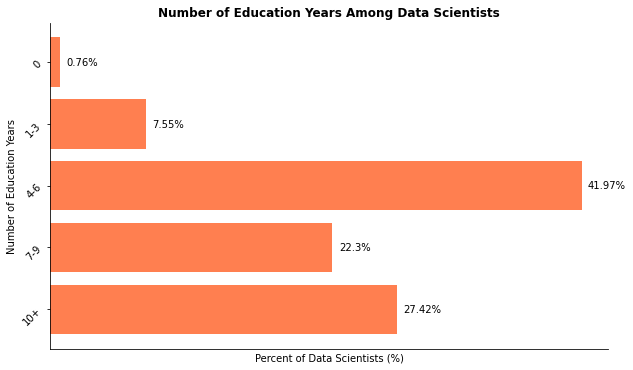

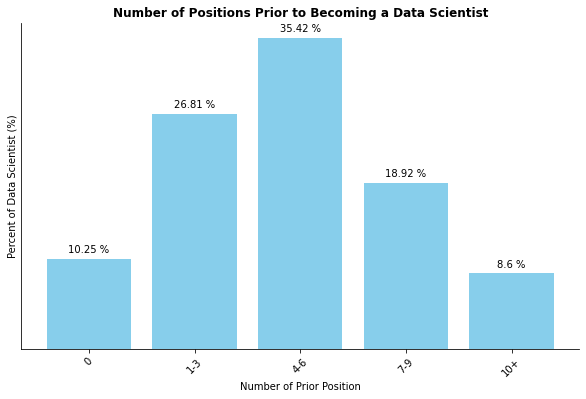

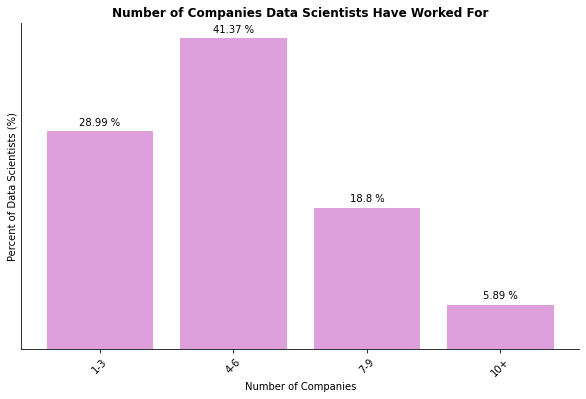

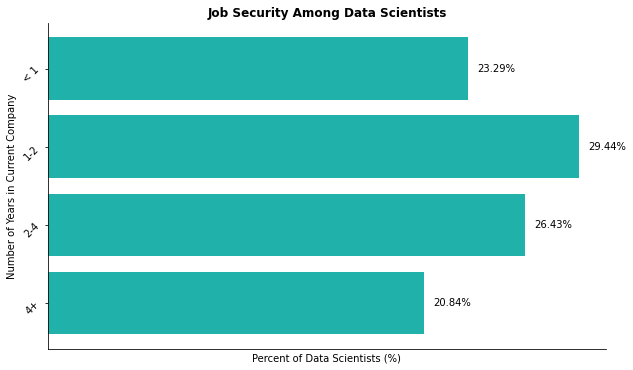

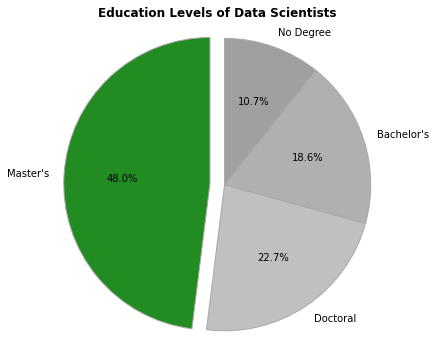

In [0]:
raw_results = run_get_big_data_distributions() # input: "data scientist", "data analyst", "software engineer"
data_for_vis, _ = run_extract_textual_insights(raw_results, prints=True)
plot_data_insights(data_for_vis)

# Run Final Dashboard Output - Slow

>>> please input a your desired position:  data scientist

>>> filtering out the users not in the desired position...
>>> extracting number of education years per user in desired position...
>>> extracting number of position per user in desired position...
>>> extracting number of companies users in desired position worked at...
>>> extracting academic background per user in desired position...
>>> extracting position duration of users in desired position...

>>> successfuly extracted the raw distributions required

>>> extracting textual insights...
***
>>> len edu list: 1,444
***
>>> creating final static dashboard...



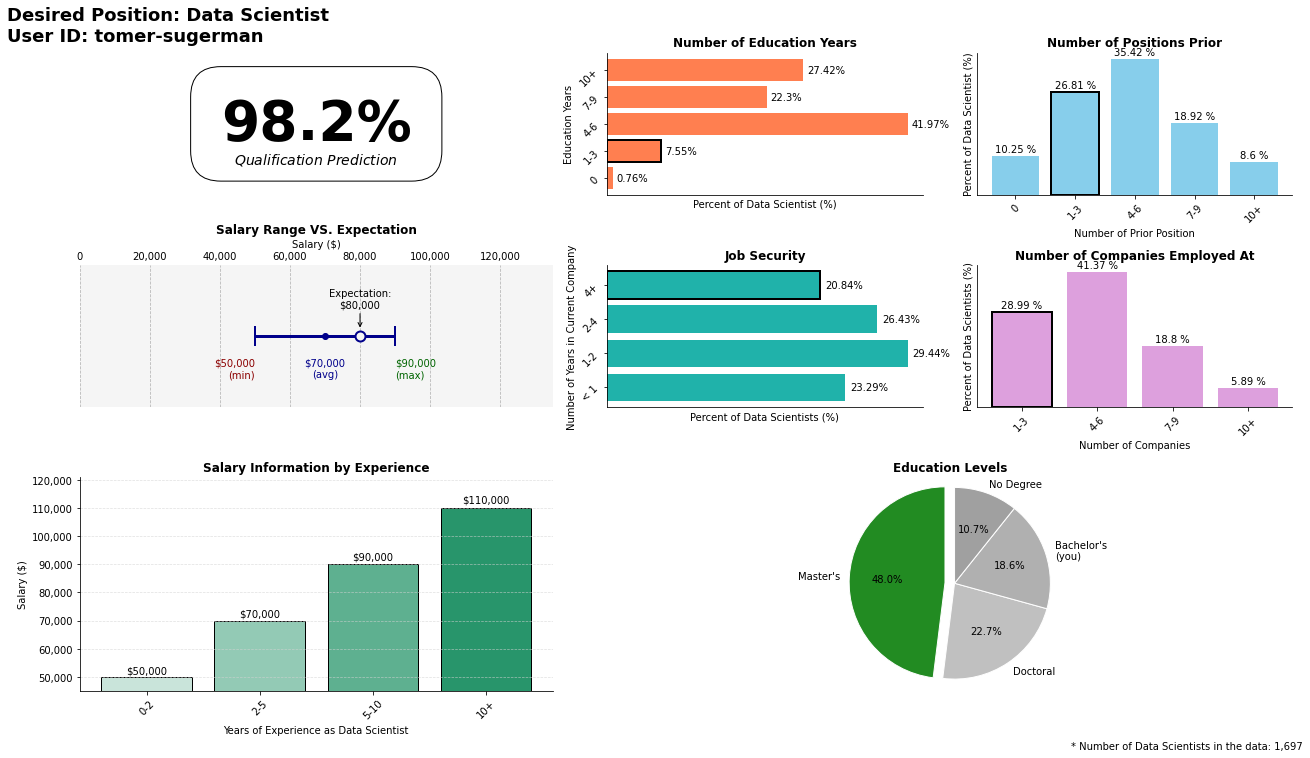

In [0]:
# -------------------------------------- just for demo purpose --------------------------------------
experience_data = {"data scientist": {'0-2': 50000, '2-5': 70000, '5-10': 90000, '10+': 110000}, "data analyst": ""}
ranges_data = {"data scientist": {'Low': 50000, 'Average': 70000, 'High': 90000}, "data analyst": {'Low': 50000, 'Average': 70000, 'High': 90000}}
salary_expectation = 80000

user_metrics = {"education_years": "1-3", "positions_prior": "1-3", "num_companies": "1-3", "job_security": "4+", "education_level": "Bachelor's"}
# ----------------------------------------------------------------------------------------------------

raw_results = run_get_big_data_distributions() # input: "data scientist", "data analyst", "software engineer"
data_for_vis, llm_dict_res = run_extract_textual_insights(raw_results)

experience_ = experience_data[data_for_vis["desired_position"]]
min_max_data = ranges_data[data_for_vis["desired_position"]]
if experience_ == "":
    create_final_dashboard_viz_missing_experience(user_metrics=user_metrics,
                                                  data_for_vis=data_for_vis,
                                                  qualification_prediction=98.2,
                                                  user_id="tomer-sugerman", 
                                                  min_max_data=min_max_data,
                                                  salary_expectation=salary_expectation)
else:
    create_final_dashboard_viz(user_metrics=user_metrics,
                               data_for_vis=data_for_vis,
                               qualification_prediction=98.2,
                               user_id="tomer-sugerman", 
                               min_max_data=min_max_data,
                               salary_expectation=salary_expectation,
                               experience_data=experience_)

>>> creating final static dashboard...



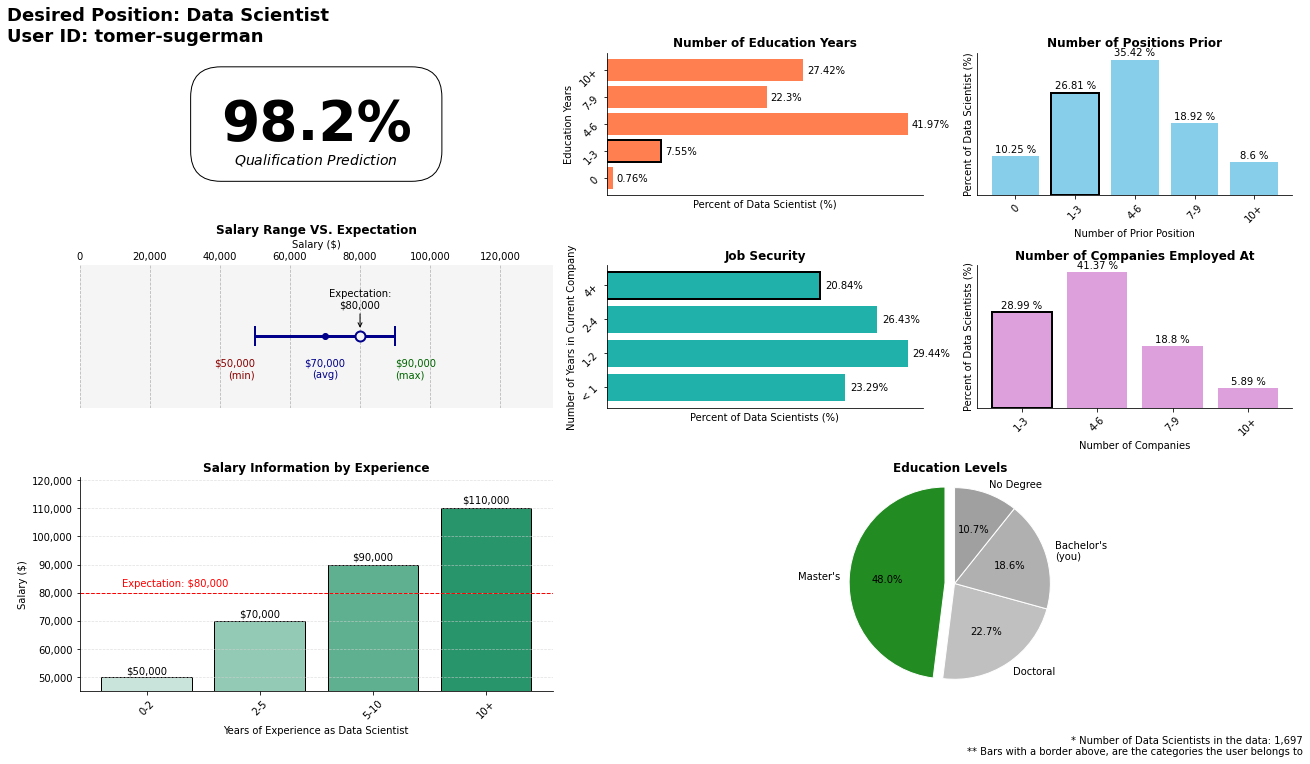

In [0]:
create_final_dashboard_viz(user_metrics=user_metrics,
                           data_for_vis=data_for_vis,
                           qualification_prediction=98.2,
                           user_id="tomer-sugerman", 
                           min_max_data=min_max_data,
                           salary_expectation=salary_expectation,
                           experience_data=experience_)

In [0]:
llm_dict_res #  input to the LLM for textual summary insights!

Out[339]: {'number_of_records': 1697,
 'education_years': 'education_years: - 0: 0.76 % - 1-3: 7.55 % - 4-6: 41.97 % - 7-9: 22.3 % - 10+: 27.42 %',
 'positions_prior': 'positions prior:- 0: 10.25 %- 1-3: 26.81 %- 4-6: 35.42 %- 7-9: 18.92 %- 10+: 8.6 %',
 'num_companies': 'num companies: - 1-3: 28.99 % - 4-6: 41.37 % - 7-9: 18.8 % - 10+: 5.89 %',
 'education_level': "education level: - Doctoral: 22.69 % - Master's: 48.03 % - Bachelor's: 18.56 % - No Degree: 10.72 %",
 'job_security_years': 'job_security_years: - < 1: 23.29 % - 1-2: 29.44 % - 2-4: 26.43 % - 4+: 20.84 %'}

# Prepare Data For Faster Response (SUPER FAST)

## Prepare

In [0]:
def get_years_of_education_df(df):
    # get number of years of education per user in desired position - returns list of number of education years
    print(">>> extracting number of education years per user in desired position...")
    tmp = df.withColumn("exploded_education", explode(col("education")))
    tmp = tmp.withColumn("edu_start_value", col("exploded_education").getItem("start_year"))
    tmp = tmp.withColumn("edu_end_value", col("exploded_education").getItem("end_year"))
    tmp = tmp.dropna(subset=["edu_start_value", "edu_end_value"])
    tmp = tmp.withColumn("edu_years", col("edu_end_value") - col("edu_start_value"))
    tmp = tmp.groupBy("id").sum("edu_years").withColumnRenamed("sum(edu_years)","total_years_education")
    tmp = tmp.sort("total_years_education", ascending=False)
    tmp = tmp.select("id", "total_years_education")
    return tmp

def get_num_positions_prior_df(df):
    print(">>> extracting number of position per user in desired position...")
    tmp = df.withColumn("exploded_experience", explode(col("experience")))
    tmp = tmp.withColumn("positions", col("exploded_experience").getItem("positions"))
    tmp = tmp.withColumn("num_positions", size(col("positions"))) # positions with null will be -1, we will abs to get 1
    tmp = tmp.withColumn("num_positions", abs(col("num_positions")))

    user_num_positions_prior_to_desired = tmp.groupBy("id").sum("num_positions")
    user_num_positions_prior_to_desired = user_num_positions_prior_to_desired.withColumn("num_positions", col("sum(num_positions)") - 1) # subtract the current position
    
    res = user_num_positions_prior_to_desired.select("id", "num_positions")
    return res

def get_num_companies_employed_df(df):
    print(">>> extracting number of companies users in desired position worked at...")
    tmp = df.withColumn("num_companies", size(col("experience")))
    tmp = tmp.select("id", "num_companies")
    return tmp


def get_academic_background_df(df):
    print(">>> extracting academic background per user in desired position...")
    
    tmp = df.withColumn("exploded_education", explode(col("education")))
    tmp = tmp.withColumn("degree", col("exploded_education").getItem("degree"))
    tmp = tmp.withColumn("degree_lower", lower(col("degree")))

    # udf mapping degree lower to the degree type - bachelor, master, phd/doctor , post-doc...
    extract_degree_type_udf = udf(lambda x: degree_type_extraction_udf(x), StringType())
    tmp = tmp.withColumn("degree_type", extract_degree_type_udf(col("degree_lower")))
    
    unique_degrees_per_user = tmp.groupBy("id").agg(collect_set("degree_type").alias("unique_degree_types"))
    
    # do this on the filtered data on positions! list(map(extract_top_degree_per_user, list_of_unique_degrees))
    tmp = unique_degrees_per_user.select("id", "unique_degree_types")
    return tmp

def get_job_security_duration_df(df):
    # extract all the positions a user worked at, we sum all duration of the positions where the desired position appeared in the title.
    print(">>> extracting position duration of users in desired position...")
    
    tmp = df.withColumn("latest_position", col("experience").getItem(0))
    tmp = tmp.withColumn("duration", col("latest_position").getItem("duration"))

    tmp = tmp.dropna(subset=["duration"])
    
    convert_duration_str_udf = udf(lambda x: convert_duration_to_num_months(x), IntegerType())
    tmp = tmp.withColumn("duration_month", convert_duration_str_udf(col("duration")))

    tmp = tmp.select("id", "duration_month")
    return tmp


def get_users_with_all_metrics():
    df = spark.read.parquet('/linkedin/people')

    df_0 = df.select("id", "position")
    df_0 = df_0.withColumn("position", lower(col("position")))

    print(f">>> num rows in data pre transformations: {df_0.count():,}")
    
    # number of education years in desired poisition
    df_1 = get_years_of_education_df(df)

    # distribution of number of position prior to the desired position
    df_2 = get_num_positions_prior_df(df)

    # distribution of number of companies profiles in desired position have worked at
    df_3 = get_num_companies_employed_df(df)
    
    # distribution of academic background
    df_4 = get_academic_background_df(df)

    # distribution of position duration
    df_5 = get_job_security_duration_df(df)

    
    df_1 = df_1.withColumnRenamed("id","id_1")
    df_2 = df_2.withColumnRenamed("id","id_2")
    df_3 = df_3.withColumnRenamed("id","id_3")
    df_4 = df_4.withColumnRenamed("id","id_4")
    df_5 = df_5.withColumnRenamed("id","id_5")

    df_0 = df_0.join(df_1, df_1.id_1 == df_0.id, how='left')
    df_0 = df_0.join(df_2, df_2.id_2 == df_0.id, how='left')
    df_0 = df_0.join(df_3, df_3.id_3 == df_0.id, how='left')
    df_0 = df_0.join(df_4, df_4.id_4 == df_0.id, how='left')
    df_0 = df_0.join(df_5, df_5.id_5 == df_0.id, how='left')

    df_0 = df_0.drop("id_1", "id_2", "id_3", "id_4", "id_5")

    print(f">>> num rows in data after transformations: {df_0.count():,}")

    return df_0

export_to_parquet = False
if export_to_parquet:
    df_to_save = get_users_with_all_metrics()
    output_path = "/dbfs/Users/jacob-link/df_for_big_data_insights.parquet" 
    df_to_save.write.mode("overwrite").parquet(output_path)
    print(">>> successfully export parquet df for big data insights")

>>> num rows in data pre transformations: 3,462,290
>>> extracting number of education years per user in desired position...
>>> extracting number of position per user in desired position...
>>> extracting number of companies users in desired position worked at...
>>> extracting academic background per user in desired position...
>>> extracting position duration of users in desired position...
>>> num rows in data after transformations: 3,462,290
>>> successfully export parquet df for big data insights


In [0]:
def convert_nas_to_list(x):
    try:
        tmp = len(x)
        return x
    except:
        return ["--"]


In [0]:
def get_lists_of_distribution_from_prepared_data(df, desired_position):
    df = df.filter(col("position").contains(desired_position))
    
    df = df.toPandas()  # once we filter the prepared data, we are going to have a df of max 40k records

    # number of users in the desired position
    number_of_users_in_position = len(df)

    # number of education years in desired poisition
    list_years_of_education = list(df["total_years_education"].fillna(0))

    # distribution of number of position prior to the desired position
    list_of_num_positions_prior = list(df["num_positions"].fillna(0))
    
    # distribution of number of companies profiles in desired position have worked at
    list_of_num_companies = list(df["num_companies"].fillna(0))
    
    # distribution of academic background
    df["unique_degree_types"] = df["unique_degree_types"].apply(convert_nas_to_list)
    list_education_level = list(map(extract_top_degree_per_user, list(df["unique_degree_types"])))

    # distribution of position duration
    list_job_security_duration = list(df["duration_month"].dropna())
    
    result = {"desired_position": desired_position, 
              "number_of_profiles": number_of_users_in_position, 
              "years_of_education_distribution": list_years_of_education,
              "num_positions_prior_distribution": list_of_num_positions_prior, 
              "num_companies_worked_at": list_of_num_companies, 
              "education_level_distribution": list_education_level, 
              "job_security_num_months_current_company_distribution": list_job_security_duration}
    
    print("\n>>> successfuly extracted the raw distributions required from the prepared data!")
    return result

In [0]:
def get_processed_raw_user_metrics(raw_user_input):
    result = {}
    result["user_position"] = raw_user_input["user_position"]
    
    years = raw_user_input["education_years"]
    try:
        if years == 0:
            edu_years = "0"
        elif 1 <= years <= 3:
            edu_years = "1-3"
        elif 4 <= years <= 6:
            edu_years = "4-6"
        elif 7 <= years <= 9:
            edu_years = "7-9"
        elif years >= 10:
            edu_years = "10+"
    except:
        edu_years = "0"
    
    result["education_years"] = edu_years
    
    
    posi = raw_user_input["positions_prior"]
    try:
        if posi == 0:
            positions_prior = "0"
        elif 1 <= posi <= 3:
            positions_prior = "1-3"
        elif 4 <= posi <= 6:
            positions_prior = "4-6"
        elif 7 <= posi <= 9:
            positions_prior = "7-9"
        elif posi >= 10:
            positions_prior = "10+"
    except:
        positions_prior = "0"
    
    result["positions_prior"] = positions_prior
                        
                        
    comps = raw_user_input["num_companies"]
    try:
        if 1 <= comps <= 3:
            num_comps = "1-3"
        elif 4 <= comps <= 6:
            num_comps = "4-6"
        elif 7 <= comps <= 9:
            num_comps = "7-9"
        elif comps >= 10:
            num_comps = "10+"
    except:
        num_comps = "0"
    
    result["num_companies"] = num_comps
                        
                        
    
    months = raw_user_input["job_security_months"]
    try:
        if months < 12:
            job_security = "< 1"
        elif months <= 24:
            job_security = "1-2"
        elif months <= 48:
            job_security = "2-4"
        elif months >= 48:
            job_security = "4+"
    except:
        job_security = "0"

    result["job_security"] = job_security
    
    deg = raw_user_input["education_level"]
    map_deg = {"master": "Master's", "bachelor": "Bachelor's", "doctor": "Doctoral", "no degree": "No Degree"}
    result["education_level"] = map_deg[deg]

    return result 
    


In [0]:
def get_user_metrics(df, user_id):
    df = df.filter(col("id") == user_id)
    row = df.collect()[0]  # extract the row for data

    try:
        edu_level = row["unique_degree_types"][0]
    except:
        edu_level = "no degree"

    raw_user_metrics = {"user_position": row["position"], 
                        "education_years": row["total_years_education"],
                        "positions_prior": row["num_positions"],
                        "num_companies": row["num_companies"], 
                        "job_security_months": row["duration_month"],
                        "education_level": edu_level}

    
    processed_user_metrics = get_processed_raw_user_metrics(raw_user_metrics)

    # print(raw_user_metrics)
    # print(processed_user_metrics)

    return raw_user_metrics, processed_user_metrics 

## Run - Fast


>>> successfuly extracted the raw distributions required from the prepared data!

>>> extracting textual insights...
>>> creating final static dashboard...



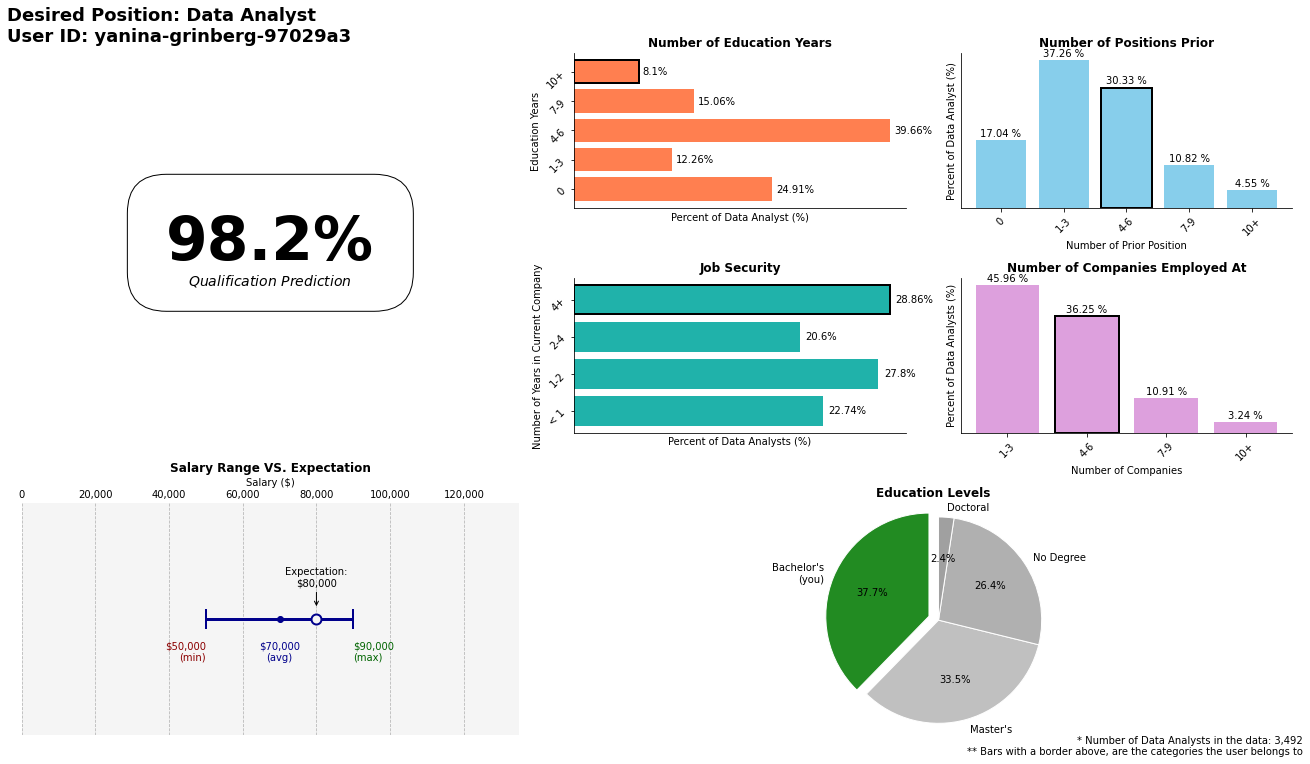

In [0]:
# -------------------------------------- just for demo purpose --------------------------------------
experience_data = {"data scientist": {'0-2': 50000, '2-5': 70000, '5-10': 90000, '10+': 110000}, "data analyst": ""}
ranges_data = {"data scientist": {'Low': 50000, 'Average': 70000, 'High': 90000}, "data analyst": {'Low': 50000, 'Average': 70000, 'High': 90000}}
salary_expectation = 80000

# user_metrics = {"user_position": "professional baller" ,"education_years": "1-3", "positions_prior": "1-3", "num_companies": "1-3", "job_security": "4+", "education_level": "Bachelor's"}
# ----------------------------------------------------------------------------------------------------
df = spark.read.parquet('/dbfs/Users/jacob-link/df_for_big_data_insights.parquet')
desired_position = "data analyst"
user_id = "yanina-grinberg-97029a3"
raw_user_metrics_llm, user_metrics = get_user_metrics(df, user_id)

raw_results = get_lists_of_distribution_from_prepared_data(df, desired_position)
data_for_vis, llm_dict_res = run_extract_textual_insights(raw_results)

experience_ = experience_data[data_for_vis["desired_position"]]
min_max_data = ranges_data[data_for_vis["desired_position"]]
if experience_ == "":
    create_final_dashboard_viz_missing_experience(user_metrics=user_metrics,
                                                  data_for_vis=data_for_vis,
                                                  qualification_prediction=98.2,
                                                  user_id=user_id, 
                                                  min_max_data=min_max_data,
                                                  salary_expectation=salary_expectation)
else:
    create_final_dashboard_viz(user_metrics=user_metrics,
                               data_for_vis=data_for_vis,
                               qualification_prediction=98.2,
                               user_id=user_id, 
                               min_max_data=min_max_data,
                               salary_expectation=salary_expectation,
                               experience_data=experience_)


# "ali-sugerman-4ba8346"
# "yanina-grinberg-97029a3"

